# driver_pareto_romsize
Generate Pareto front plot for LS-ROM and NM-ROM by varying ROM size.  
Author: Alejandro Diaz  
Date modified: 1/4/2023

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import dill as pickle
from time import time
import sys, os
from matplotlib.ticker import StrMethodFormatter, NullFormatter

from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model
from utils.LS_ROM import compute_bases_from_svd, DD_LS_ROM
from utils.NM_ROM import DD_NM_ROM, separate_snapshots, RBFmdl

/usr/workspace/diaz64/anaconda/envs/opence-1.7.2-cuda-11.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = './data/'
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

# Build full-domain FOM and DD-FOM

In [3]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]
A, Lam  = np.meshgrid(np.linspace(a1_lim[0], a1_lim[1], na1), np.linspace(lam_lim[0], lam_lim[1], nlam))
Mu      = np.vstack([A.flatten(), Lam.flatten()]).T

a1, lam = 7692.5384, 21.9230
viscosity = 1e-1

# number of subdomains in x and y directions for DD model
n_sub_x = 2
n_sub_y = 2

n_sub   = n_sub_x*n_sub_y
act_type = 'Swish' 
romsize_list = [4, 6, 8, 10, 16]

In [4]:
# store directory names for figures
fig_dir  = f'./figures/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
svd_dir  = f'./data/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
ls_figs = fig_dir + 'lsrom/'
nm_figs = fig_dir + 'nmrom/'
for d in [fig_dir, ls_figs, nm_figs]:
    if not os.path.exists(d):
        os.mkdir(d)

In [5]:
# load snapshot and residual data
file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_400.p'
data = pickle.load(open(file, 'rb'))
Mu = data['parameters']
snapshots = data['snapshots']
residuals = data['residuals']

# # load snapshot and residual data
# file = f'./data/snapshot_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_6400.p'
# data = pickle.load(open(file, 'rb'))
# Mu = data['parameters']
# snapshots = data['snapshots']

In [6]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving full domain model:')
sys.stdout.flush()
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=False)
sol_fd = np.concatenate([u_fom, v_fom])

# compute Burgers DD FOM
ddmdl = DD_model(fom, n_sub_x, n_sub_y)
ndof_fom = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl.subdomain]) \
            + ddmdl.subdomain[0].constraint_mat.shape[0]
w0 = np.zeros(ndof_fom)
print('\nSolving DD model:')
sys.stdout.flush()
u_dd_fom, v_dd_fom, u_intr, v_intr, u_intf, v_intf, lam_fom, fom_time, itr = ddmdl.solve(w0, tol=1e-9, 
                                                                           maxit=15,
                                                                           print_hist=True)
sol_dd_fom = np.concatenate([u_dd_fom, v_dd_fom])

dd_fom_rel_err = np.linalg.norm(sol_dd_fom-sol_fd)/np.linalg.norm(sol_fd)
print(f'\nDD-FOM relative error = {dd_fom_rel_err:1.4e}')
sys.stdout.flush()

Solving full domain model:
Starting Newton solver...
Newton solver terminated after 14 iterations with residual 5.9127e-09.

Solving DD model:
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.815e+11
   1       1.000e+00      8.885e+09
   2       1.000e+00      1.273e+09
   3       1.000e+00      1.318e+08
   4       1.000e+00      1.119e+07
   5       1.000e+00      9.497e+05
   6       1.000e+00      8.095e+04
   7       1.000e+00      6.929e+03
   8       1.000e+00      5.963e+02
   9       1.000e+00      5.165e+01
  10       1.000e+00      4.507e+00
  11       1.000e+00      3.968e-01
  12       1.000e+00      3.526e-02
  13       1.000e+00      3.172e-03
  14       1.000e+00      3.552e-04
  15       1.000e+00      2.127e-04
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 2.1273e-04.

DD-FOM relative error = 8.6156e-16


## LS-ROM

In [7]:
# energy criteria for number of residual basis vectors
ec_res  = 1e-10

# number of interior and interface basis vectors
nbasis_res = -1
nbasis_intr = -1
nbasis_intf = -1
    
# load SVD data
Ntotal = 6400 if nx in [240, 480] else 4200
print('Loading SVD data...')
intr_dict = pickle.load(open(svd_dir+f'intr_svd_nsnaps_{Ntotal}.p', 'rb'))
intf_dict = pickle.load(open(svd_dir+f'intf_svd_nsnaps_{Ntotal}.p', 'rb'))
res_dict  = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
print('Data loaded!')

# compute bases
print('Computing bases...')
interior_bases_large = compute_bases_from_svd(intr_dict, nbasis=max(romsize_list))
interface_bases_large = compute_bases_from_svd(intf_dict, nbasis=max(romsize_list))
residual_bases = compute_bases_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res)
print('Bases computed!')

for i in range(n_sub):
    print(f'residual_bases[{i}]={residual_bases[i].shape}')
for i in range(n_sub):
    print(f'interior_bases[{i}]={interior_bases_large[i].shape}') 
for i in range(n_sub):
    print(f'interface_bases[{i}]={interface_bases_large[i].shape}')    
sys.stdout.flush()

Loading SVD data...
Data loaded!
Computing bases...
Bases computed!
residual_bases[0]=(5760, 19)
residual_bases[1]=(5760, 48)
residual_bases[2]=(5760, 25)
residual_bases[3]=(5760, 64)
interior_bases[0]=(5258, 16)
interior_bases[1]=(5258, 16)
interior_bases[2]=(5258, 16)
interior_bases[3]=(5258, 16)
interface_bases[0]=(1006, 16)
interface_bases[1]=(1006, 16)
interface_bases[2]=(1006, 16)
interface_bases[3]=(1006, 16)


In [8]:
lsrom_rel_times = np.zeros(len(romsize_list))
lsrom_rel_errors = np.zeros(len(romsize_list))

for j, romsize in enumerate(romsize_list):
    interior_bases = []
    interface_bases = []
    for i in range(n_sub):
        interior_bases.append(interior_bases_large[i][:, :romsize])
        interface_bases.append(interface_bases_large[i][:, :romsize//2])
        
    # compute DD LS-ROM
    print('Building DD LS-ROM...')
    print(f'Interior basis size = {interior_bases[0].shape[1]}')
    print(f'Interface basis size = {interface_bases[0].shape[1]}')
    sys.stdout.flush()
    ddlsrom = DD_LS_ROM(ddmdl, residual_bases, interior_bases, interface_bases, 
                        hr=True,
                        hr_type='collocation',
                        sample_ratio=3, 
                        n_samples=100,
                        n_corners=25,
                        constraint_type='weak', 
                        n_constraints=1)
    print('ROM built!\n')
    sys.stdout.flush()

    # solve DD ROM
    print('Solving DD LS-ROM...')
    sys.stdout.flush()

    ndof_rom = np.sum([s.n_interior+s.n_interface for s in ddlsrom.subdomain]) \
                + ddlsrom.n_constraints
    w0 = np.zeros(ndof_rom)
    u_dd_rom, v_dd_rom, w_intr, w_intf, lam_ls, rom_time, itr = ddlsrom.solve(w0, tol=1e-4, maxit=15, print_hist=True)
    print('Solution found!\n')
    sys.stdout.flush()

    # compute error
    dd_rom_rel_err = ddlsrom.compute_error(w_intr, w_intf, u_intr, v_intr, u_intf, v_intf)
    print(f'DD-ROM rel. error = {dd_rom_rel_err:1.4e}')
    print(f'Speedup = {fom_time/rom_time}')
    sys.stdout.flush()
    
    lsrom_rel_times[j]  = rom_time/fom_time
    lsrom_rel_errors[j] = dd_rom_rel_err

Building DD LS-ROM...
Interior basis size = 4
Interface basis size = 2
ROM built!

Solving DD LS-ROM...
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      8.591e+09
   1       1.000e+00      3.648e+08
   2       1.000e+00      1.190e+06
   3       1.000e+00      8.135e+02
   4       1.000e+00      1.059e+00
   5       1.000e+00      2.088e-03
   6       1.000e+00      3.356e-06
Newton solver terminated after 6 iterations with residual 3.3560e-06.
Solution found!

DD-ROM rel. error = 3.5528e-02
Speedup = 75.06383823490808
Building DD LS-ROM...
Interior basis size = 6
Interface basis size = 3
ROM built!

Solving DD LS-ROM...
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      1.010e+10
   1       1.000e+00      4.613e+08
   2       1.000e+00      1.372e+06
   3       1.000e+00      4.422e+02
   4       1.000e+00      5.085e-01
   5       1.000e+00      6.888e-04
   6       1.000e+00      1.244e-06
Newton solver termin

## NM-ROM

In [9]:
# restrict snapshots to interior and interface subdomains
interior, interface = separate_snapshots(ddmdl, snapshots)

In [10]:
net_folder0 = f'./trained_nets/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
Ntotal = 6400 if nx in [240, 480] else 4200
nmrom_rel_times = np.zeros(len(romsize_list))
nmrom_rel_errors = np.zeros(len(romsize_list))

for j, r in enumerate(romsize_list):
    intr_net_list = [net_folder0+\
                     f'sub_{i+1}of{n_sub}/interior/'+\
                     f'ld_{r}_rnnz_5_rshift_5_{act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                      for i in range(n_sub)]
    intf_net_list = [net_folder0+\
                     f'sub_{i+1}of{n_sub}/interface/'+\
                     f'ld_{r//2}_rnnz_5_rshift_5_{act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                      for i in range(n_sub)]
        
    # compute DD -ROM
    print('Building DD NM-ROM...')
    print(f'Interior latent dim = {r}')
    print(f'Interface latent dim = {r//2}')
    sys.stdout.flush()
    ddnmrom = DD_NM_ROM(ddmdl, 
                        intr_net_list,
                        intf_net_list,
                        residual_bases,
                        hr=True, 
                        sample_ratio=3,
                        n_samples=100, 
                        n_corners=25, 
                        constraint_type='weak', 
                        n_constraints=1,
                        seed=10)
    print('ROM built!\n')
    sys.stdout.flush()
    
    print('Computing RBF interpolant...')
    rbfmdl = RBFmdl(ddnmrom, Mu, interior, interface, neighbors=None, kernel='linear')
    print('Interpolant computed!')

    # solve DD ROM
    print('Solving DD NM-ROM...')
    sys.stdout.flush()

    ndof_rom = np.sum([s.intr_latent_dim+s.intf_latent_dim for s in ddnmrom.subdomain]) \
                       + ddnmrom.n_constraints
    
#     w0 = np.zeros(ndof_rom)

    initial_time = time()
    w0, lam0 = rbfmdl.get_initial(np.array([[a1, lam]]), ddnmrom)
    w0 = np.concatenate([w0, lam0])
    initial_time = time()-initial_time

    u_dd_rom, v_dd_rom, w_intr, w_intf, lam_opt, rom_time, itr = ddnmrom.solve(w0, tol=1e-3, maxit=15, print_hist=True)
    rom_time += initial_time
    print('Solution found!\n')
    sys.stdout.flush()

    # compute error
    dd_rom_rel_err = ddnmrom.compute_error(w_intr, w_intf, u_intr, v_intr, u_intf, v_intf)
    print(f'DD NM-ROM rel. error = {dd_rom_rel_err:1.4e}')
    print(f'Speedup = {fom_time/rom_time}')
    sys.stdout.flush()
    
    nmrom_rel_times[j]  = rom_time/fom_time
    nmrom_rel_errors[j] = dd_rom_rel_err
    

Building DD NM-ROM...
Interior latent dim = 4
Interface latent dim = 2
Using device: cuda
ROM built!

Computing RBF interpolant...
Interpolant computed!
Solving DD NM-ROM...
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      6.963e+10
   1       1.000e+00      9.941e+09
   2       1.000e+00      6.796e+08
   3       1.000e+00      1.960e+08
   4       1.000e+00      3.015e+07
   5       1.000e+00      6.688e+06
   6       1.000e+00      1.311e+06
   7       1.000e+00      2.499e+05
   8       1.000e+00      4.724e+04
   9       1.000e+00      8.923e+03
  10       1.000e+00      1.684e+03
  11       1.000e+00      3.180e+02
  12       1.000e+00      6.002e+01
  13       1.000e+00      1.133e+01
  14       1.000e+00      2.139e+00
  15       1.000e+00      4.037e-01
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 4.0368e-01.
Solution found!

DD NM-ROM rel. error = 7.0422e-03
Speedup = 11.3501752518

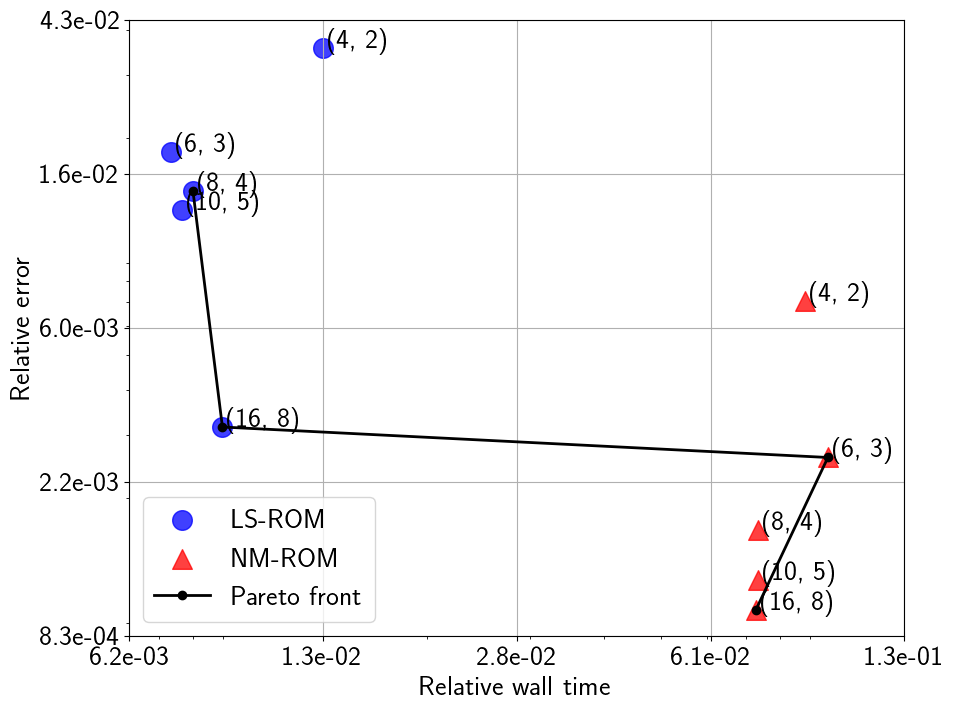

In [11]:
# plot pareto fronts
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(lsrom_rel_times, lsrom_rel_errors, s=200, c='blue', marker='o', label='LS-ROM', alpha=0.75)
ax.scatter(nmrom_rel_times, nmrom_rel_errors, s=200, c='red', marker='^', label='NM-ROM', alpha=0.75)
for i, r in enumerate(romsize_list):
    ax.text(lsrom_rel_times[i]*1.02, lsrom_rel_errors[i], (r, r//2))
    ax.text(nmrom_rel_times[i]*1.02, nmrom_rel_errors[i], (r, r//2))

front_x = np.array([lsrom_rel_times[2], lsrom_rel_times[-1],
                    nmrom_rel_times[1], nmrom_rel_times[-1]])
front_y = np.array([lsrom_rel_errors[2], lsrom_rel_errors[-1],
                    nmrom_rel_errors[1], nmrom_rel_errors[-1]])

ax.plot(front_x, front_y, 'k.-', markersize=12, linewidth=2, label='Pareto front')

ax.set_yscale('log')
ax.set_xscale('log')

xlim = [min(lsrom_rel_times.min(), nmrom_rel_times.min())*0.85, 
        max(lsrom_rel_times.max(), nmrom_rel_times.max())*1.35]
ylim = [min(lsrom_rel_errors.min(), nmrom_rel_errors.min())*0.85,
        max(lsrom_rel_errors.max(), nmrom_rel_errors.max())*1.2]

xtick_locs = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 5)
xtick_labels = [f'{v:1.1e}' for v in xtick_locs]
ytick_locs = np.logspace(np.log10(ylim[0]), np.log10(ylim[1]), 5)
ytick_labels = [f'{v:1.1e}' for v in ytick_locs]

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks(xtick_locs, xtick_labels)
ax.set_yticks(ytick_locs, ytick_labels)

ax.set_xlabel('Relative wall time')
ax.set_ylabel('Relative error')
ax.grid()
ax.legend(loc='lower left')
hr_str = '_col_hr' if ddnmrom.hr else ''
file = fig_dir+f'pareto_romsize{hr_str}.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)

In [12]:
[4*r+2*r for r in romsize_list]

[24, 36, 48, 60, 96]

In [13]:
np.insert(nmrom_rel_times[1:], 0, lsrom_rel_times[2])

array([0.00798452, 0.09635698, 0.07335848, 0.07335641, 0.07262217])

In [14]:
nmrom_rel_times

array([0.08810437, 0.09635698, 0.07335848, 0.07335641, 0.07262217])

In [15]:
lsrom_rel_times

array([0.01332199, 0.00732189, 0.00798452, 0.00764342, 0.00896416])